In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
K = 30  
N = 60  
snrdb_low = 7.0
snrdb_high = 14.0
snr_low = 10.0 ** (snrdb_low/10.0)
snr_high = 10.0 ** (snrdb_high/10.0)
size = 1000

def data_generation_VC(K, N, size, snr_low, snr_high):
    x = np.random.randint(2, size=(size, K))*2.0-1 
    n = np.random.randn(size, N) 
    y = np.empty(shape=[size, N]) 
    Hy = np.empty(shape=[size, K])
    HH = np.zeros([size, K, K])
    current_snr = 10.0 ** (np.random.uniform(low=snr_low,high=snr_high, size=size)/10.0)
    for i in range(size):
        H = np.random.randn(N, K)*1.0/np.sqrt(N)  
        HH[i,:,:] = H.T.dot(H) 
        y[i,:] = (H.dot(x[i,:])+n[i,:]*np.sqrt((HH[i,:,:]).trace()/K)/np.sqrt(current_snr[i]))
        Hy[i,:] = H.T.dot(y[i,:]) 
    return y, Hy, HH, current_snr, x

In [ ]:
def data_generation_VC(K, N, size, snr_low, snr_high):
    x = np.random.randint(2, size=(size, K))*2.0-1 
    n = np.random.randn(size, N) 
    y = np.empty(shape=[size, N]) 
    Hy = np.empty(shape=[size, K])
    HH = np.zeros([size, K, K])
    current_snr = 10.0 ** (np.random.uniform(low=snr_low,high=snr_high, size=size)/10.0)
    for i in range(size):
        H = np.random.randn(N, K)*1.0/np.sqrt(N)  
        HH[i,:,:] = H.T.dot(H) 
        y[i,:] = (H.dot(x[i,:])+n[i,:]*np.sqrt((HH[i,:,:]).trace()/K)/np.sqrt(current_snr[i]))
        Hy[i,:] = H.T.dot(y[i,:]) 
    return y, Hy, HH, current_snr, x

In [ ]:

# Definition of the piecewise linear soft sign operator.
def linear_soft_sign(x):
    t = tf.Variable(np.random.uniform())
    y = -1+tf.nn.relu(x+t)/(tf.abs(t))-tf.nn.relu(x-t)/(tf.abs(t))
    return y


In [ ]:
layers = 3*K
v_len = 2*K
z_len = 8*K

test_steps= 1000
batch_size_test = 500
snr_range = np.arange(8, 14, 1)

training_steps = 1000
batch_size_train = 500
snr_var_train = 3.0

def linear_traformation(x, input_size, output_size):
    W = tf.Variable(tf.random_normal([input_size, output_size], stddev=0.01))
    w = tf.Variable(tf.random_normal([1, output_size], stddev=0.01))
    y = tf.matmul(x, W) + w
    return y

In [ ]:
sess = tf.InteractiveSession()
# Inputs of the DetNet.
x_input = tf.placeholder(tf.float32,shape=[None,K])
Hy_input = tf.placeholder(tf.float32,shape=[None,K])
HH_input = tf.placeholder(tf.float32,shape=[None, K , K])
x = []
x.append(tf.zeros([tf.shape(x_input)[0], K]))

xt = []
xt.append(tf.zeros([tf.shape(x_input)[0], K]))

v = []
v.append(tf.zeros([tf.shape(x_input)[0], v_len]))
l = []
l.append(tf.zeros([]))
ber = []
ber.append(tf.zeros([]))
ber_zf = []
ber_zf.append(tf.zeros([]))
x_optimal = tf.squeeze(tf.matmul(tf.expand_dims(Hy_input,1),tf.matrix_inverse(HH_input)), 1)
for i in range(1,layers+1):
    concat = tf.concat([Hy_input, v[-1], x[-1], tf.squeeze(tf.matmul(tf.expand_dims(x[-1], 1), HH_input), 1)],1)
    z = tf.nn.relu(linear_traformation(concat, 3*K + v_len, z_len))
     
    xt.append(xt[-1] + linear_traformation(z, z_len, K))     
    x.append(linear_soft_sign(xt[-1]))

    v.append(v[-1] + linear_traformation(z , z_len , v_len))
    
    l.append(np.log(i)*tf.reduce_mean(tf.reduce_mean(tf.square(x_input - x[-1]),1)/tf.reduce_mean(tf.square(x_input - x_optimal),1)))
    

    ber.append(tf.reduce_mean(tf.cast(tf.not_equal(x_input, tf.sign(x[-1])), tf.float32)))
    
    
    ber_zf.append(tf.reduce_mean(tf.cast(tf.not_equal(x_input, tf.sign(x_optimal)), tf.float32)))

In [ ]:

loss = tf.add_n(l)
train_step = tf.train.AdamOptimizer().minimize(loss)


sess.run(tf.initialize_all_variables())


tmp_result = []
ber_samples = np.zeros((np.floor_divide(training_steps,100), len(snr_range), test_steps))

for i in range(training_steps):

    y_train, Hy_train, HH_train, snr_train, x_train = data_generation_VC(K, N, batch_size_train, snr_low, snr_var_train)

    train_step.run(feed_dict={Hy_input: Hy_train, HH_input: HH_train, x_input: x_train})
    if i%500 == 0: 
        tmp_result.append(sess.run([l, ber], {Hy_input: Hy_train, HH_input: HH_train, x_input: x_train}))
        print('Train step ', i, ', current loss: ', tmp_result[-1][0][-1], ', current ber: ', tmp_result[-1][1][-1])

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Train step  0 , current loss:  6.731719 , current ber:  0.40246665
Train step  500 , current loss:  1.5652323 , current ber:  0.09193333


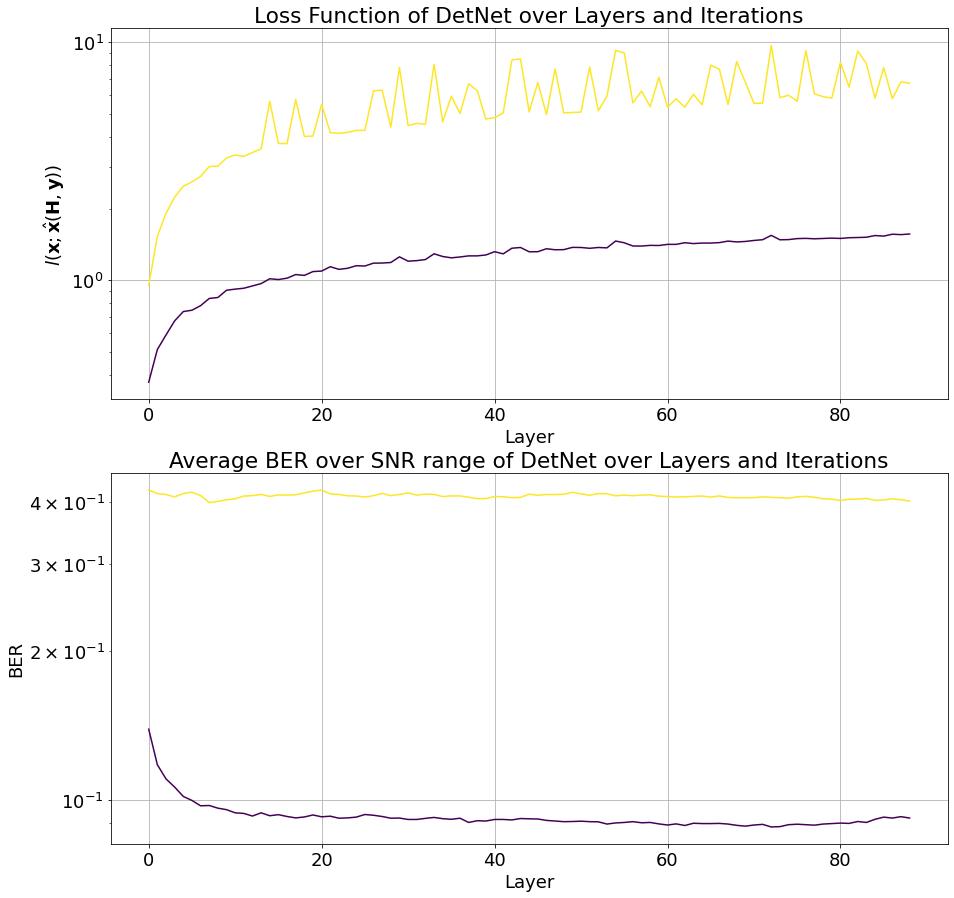

In [ ]:
# Visualize Training.

fig = plt.figure(1,figsize=(15,15))
plt.rcParams.update({'font.size': 18})
color=iter(cm.viridis_r(np.linspace(0,1,np.size(tmp_result, 0))))
# Plot loss.
plt.subplot(211)
for i in range(0, np.size(tmp_result, 0)):
    c=next(color)
    plt.semilogy(range(0, np.size(tmp_result, 2)-2), tmp_result[i][0][2:], color=c)
plt.grid(True)
plt.title("Loss Function of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel(r"$l(\mathbf{x};\hat{\mathbf{x}}(\mathbf{H}, \mathbf{y}))$")
# Plot BER.
plt.subplot(212)
color=iter(cm.viridis_r(np.linspace(0,1,np.size(tmp_result, 0))))
for i in range(0, np.size(tmp_result, 0)):
    c=next(color)
    plt.semilogy(range(0, np.size(tmp_result, 2)-2), tmp_result[i][1][2:], color=c)
plt.grid(True)
plt.title("Average BER over SNR range of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_layers.pdf", format='pdf')

In [ ]:
ber_test = np.zeros((len(snr_range), test_steps))
ber_zf_test = np.zeros((len(snr_range), test_steps))
for c, tmp_snr in enumerate(snr_range):
    for i in range(test_steps):
        y_test, Hy_test, HH_test, snr_test, x_test= data_generation_VC(K, N, batch_size_test, tmp_snr, 0.0)
        bers = np.array(sess.run([ber[layers-1], ber_zf[layers-1]], {Hy_input: Hy_test, HH_input: HH_test, x_input: x_test}))
        ber_test[c][i] =  bers[0]
        ber_zf_test[c][i] = bers[1]
    print('SNR ', tmp_snr, 'BER = ', np.mean(ber_test[c]), ' ZF = ', np.mean(ber_zf_test[c]))

SNR  8 BER =  0.09927546667307616  ZF =  0.1342434668764472
SNR  9 BER =  0.09002826662361622  ZF =  0.12283126663416624
SNR  10 BER =  0.08195986667275429  ZF =  0.11245073345303536
SNR  11 BER =  0.07537286677956581  ZF =  0.10345939992368221
SNR  12 BER =  0.06921286674961448  ZF =  0.09529326652735472
SNR  13 BER =  0.06384466676041484  ZF =  0.08783393327891827


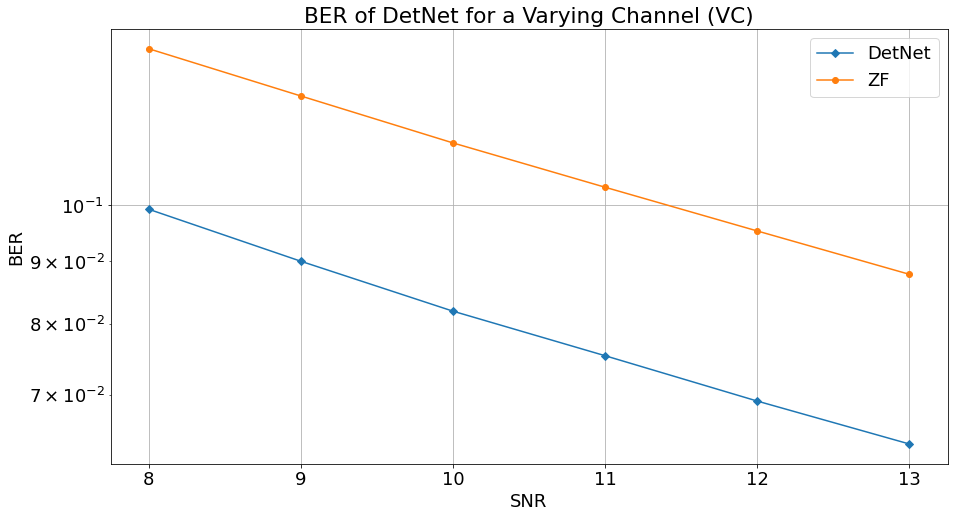

In [ ]:
# Plot BER curve.
fig = plt.figure(1,figsize=(15,8))
ber_res = np.mean(ber_test, axis=1)
ber_zf_res = np.mean(ber_zf_test, axis=1)
plt.figure(1,figsize=(15,8))
plt.rcParams.update({'font.size': 18})
plt.semilogy(snr_range, ber_res, marker='D')
plt.semilogy(snr_range, ber_zf_res, marker='o')
plt.legend(['DetNet', 'ZF'])
plt.grid(True)
plt.title("BER of DetNet for a Varying Channel (VC)")
plt.xlabel("SNR")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_BER.pdf", format='pdf')